In [72]:
import pandas as pd
import numpy as np
import os
import re


import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
def extract_number(s):
    match = re.search(r'\d+', s)
    if match:
        return int(match.group())  # Convert found string to integer
    return None  # In case no digits are found

def list_files_with_extension(target_dir, extension):
    # Ensure the extension starts with a dot
    if not extension.startswith('.'):
        extension = '.' + extension
    
    # List all files in the directory with the specific extension
    try:
        matching_files = [f for f in os.listdir(target_dir) if f.endswith(extension)]
    except FileNotFoundError:
        print(f"Directory not found: {target_dir}")
        return []
    matching_files.sort()
    
    return matching_files

def read_files(target_dir, extension):
    file_list = list_files_with_extension(target_dir, extension)
    df_list = []
    
    for file in file_list:
        
        file_parts = file.split("_")
        ref_pop = file_parts[0]
        gwas_pop = file_parts[1]
        ratio = file_parts[2]
        # get the numeric part of the replicate
        replicate = extract_number(file_parts[3])
        
        file_path = os.path.join(target_dir, file)
        
        try:
            df = pd.read_fwf(file_path, header=0)
        except Exception as e:
            print(f"Failed to read {file_path}: {str(e)}")
            
        df['ref_pop'] = ref_pop
        # set AMR as 0 and EAS as 1
        df['ref_pop'] = df['ref_pop'].replace({'AMR': '0', 'EAS': '1'})
        df['ref_pop'] = df['ref_pop'].astype(int)
        df['gwas_pop'] = gwas_pop
        # set page as 0 and bbj as 1
        df['gwas_pop'] = df['gwas_pop'].replace({'page': '0', 'bbj': '1'})
        df['gwas_pop'] = df['gwas_pop'].astype(int)
        df['ratio'] = ratio
        df['ratio'] = df['ratio'].astype(float)
        df['PHENO'] = df['PHENO'].replace({1: 0, 2: 1})
        df['replicate'] = replicate
        
        # drop columns that are not needed
        df = df.drop('FID', axis=1)
        
        df_list.append(df)
    
    return df_list

PHENO==0 is control and PHENO==1 is case

In [3]:
# AMR data
target_dir = '/wynton/scratch/BMI206_NIC/noahs_project/plink_out/AMR'
extension = '.profile'

df_list_AMR = read_files(target_dir, extension)

In [4]:
# EAS data
target_dir = '/wynton/scratch/BMI206_NIC/noahs_project/plink_out/EAS'
extension = '.profile'

df_list_EAS = read_files(target_dir, extension)

In [5]:
df_lists = df_list_AMR + df_list_EAS

In [6]:
df = pd.concat(df_lists, ignore_index=True)

And now that I have the whole df, I will run the model on it!

# Normalizing

In [7]:
df['CNT_ratio'] = df['CNT2']/df['CNT']

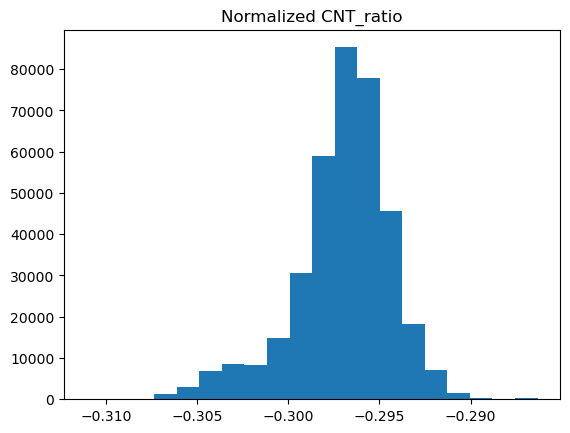

In [8]:
plt.hist(np.log(df['CNT_ratio']), bins=20)
plt.title('Normalized CNT_ratio')
plt.show()

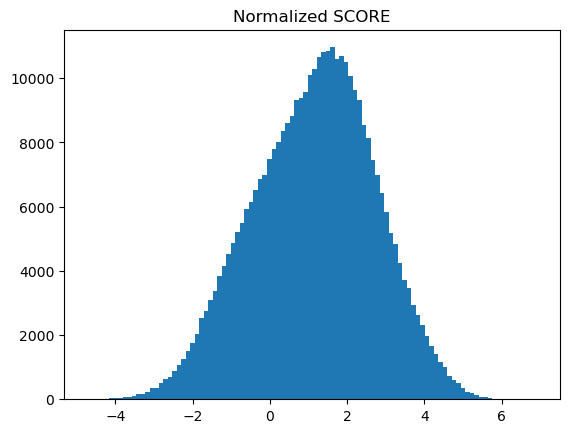

In [10]:
plt.hist(np.log(df['SCORE'] + 1)*1e5, bins=100)
plt.title('Normalized SCORE')
plt.show()

In [11]:
# normalize the SCRORE
df['SCORE_norm'] = np.log(df['SCORE'] + 1) * 1e5

# normalize the CNT_ratio
# df['CNT_ratio_norm'] = np.log(df['CNT_ratio'] + 1)

In [12]:
df['SCORE_norm'].describe()

count    368893.000000
mean          1.145482
std           1.574107
min          -4.741182
25%           0.049946
50%           1.237022
75%           2.258494
max           6.925650
Name: SCORE_norm, dtype: float64

It is very small!

In [13]:
# drop any NaN columns created with the normalization
df = df.dropna(axis=0, how='any')

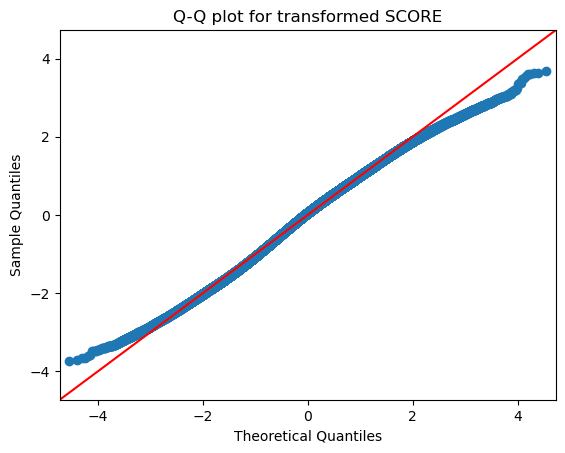

In [14]:
# Generating the Q-Q plot for the transformed SCORE
fig = sm.qqplot(df['SCORE_norm'], line='45', fit=True)
plt.title('Q-Q plot for transformed SCORE')
plt.show()

# Modeling

In [19]:
df.sort_values(['IID', 'ratio']).head(20)

,IID,PHENO,CNT,CNT2,SCORE,ref_pop,gwas_pop,ratio,replicate,CNT_ratio,SCORE_norm
55,10001201,1,785652,585833,0.000015,0,1,0.01,1,0.745665,1.498169
2117,10001201,1,785652,585833,0.000031,0,1,0.01,2,0.745665,3.068423
4179,10001201,1,785652,585833,0.000022,0,1,0.01,3,0.745665,2.212536
6241,10001201,1,785652,585833,0.000020,0,1,0.01,4,0.745665,1.963041
8303,10001201,1,785652,585833,0.000002,0,1,0.01,5,0.745665,0.194923
90783,10001201,1,786230,586442,0.000022,0,0,0.01,1,0.745891,2.219135
92845,10001201,1,786230,586442,0.000043,0,0,0.01,2,0.745891,4.263249
94907,10001201,1,786230,586442,0.000005,0,0,0.01,3,0.745891,0.539760
96969,10001201,1,786230,586442,0.000024,0,0,0.01,4,0.745891,2.380312
99031,10001201,1,786230,586442,0.000004,0,0,0.01,5,0.745891,0.443318


In [15]:
df.dtypes

IID            object
PHENO           int64
CNT             int64
CNT2            int64
SCORE         float64
ref_pop         int64
gwas_pop        int64
ratio         float64
replicate       int64
CNT_ratio     float64
SCORE_norm    float64
dtype: object

In [16]:
df.columns

Index(['IID', 'PHENO', 'CNT', 'CNT2', 'SCORE', 'ref_pop', 'gwas_pop', 'ratio',
       'replicate', 'CNT_ratio', 'SCORE_norm'],
      dtype='object')

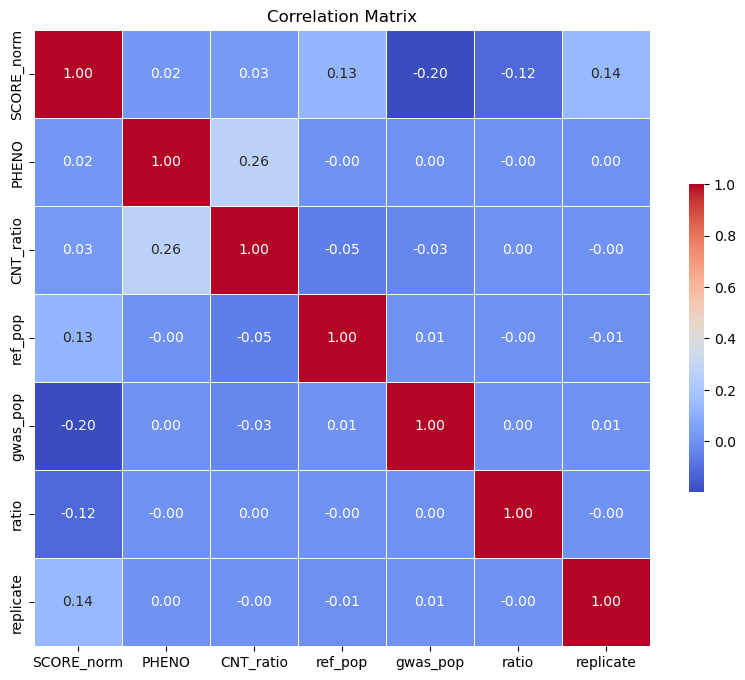

In [17]:
# Check the correlation matrix of predictors
corr_matrix = df[['SCORE_norm', 'PHENO', 'CNT_ratio', 'ref_pop', 'gwas_pop', 'ratio', 'replicate']].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Add title
plt.title('Correlation Matrix')

# Show the plot
plt.show()


Everything seems fine!

In [71]:
corr_matrix

,SCORE_norm,PHENO,CNT_ratio,ref_pop,gwas_pop,ratio,replicate
SCORE_norm,1.000000,2.038719e-02,0.026450,1.294628e-01,-0.197779,-0.115143,0.143493
PHENO,0.020387,1.000000e+00,0.264326,-2.166549e-07,0.000041,-0.000027,0.000045
CNT_ratio,0.026450,2.643260e-01,1.000000,-5.327487e-02,-0.030028,0.000354,-0.000049
ref_pop,0.129463,-2.166549e-07,-0.053275,1.000000e+00,0.005859,-0.000664,-0.007900
gwas_pop,-0.197779,4.068345e-05,-0.030028,5.859071e-03,1.000000,0.000570,0.008054
ratio,-0.115143,-2.662192e-05,0.000354,-6.635750e-04,0.000570,1.000000,-0.001199
replicate,0.143493,4.513763e-05,-0.000049,-7.900393e-03,0.008054,-0.001199,1.000000


## Normal linear regression

In [38]:
df_smooshest = df.groupby(['ratio']).agg({'SCORE_norm': 'mean'}).reset_index()

In [40]:
df_smoosh = df.groupby(['ratio', 'ref_pop', 'gwas_pop', 'PHENO']).agg({'SCORE_norm': 'mean'}).reset_index()

In [57]:
# simple linear regression
formula = 'SCORE_norm ~ ratio'

# Fit the linear model
model_lr1 = smf.ols(formula, data=df).fit()

# Print the summary of the model
print(model_lr1.summary())

                            OLS Regression Results                            
Dep. Variable:             SCORE_norm   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     4956.
Date:                Thu, 05 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:06:19   Log-Likelihood:            -6.8834e+05
No. Observations:              368893   AIC:                         1.377e+06
Df Residuals:                  368891   BIC:                         1.377e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4028      0.004    313.753      0.0

In [76]:
# simple linear regression
formula = 'SCORE_norm ~ ratio + gwas_pop + ref_pop'

# Fit the linear model
model_lr2 = smf.ols(formula, data=df).fit()

# Print the summary of the model
print(model_lr2.summary())

                            OLS Regression Results                            
Dep. Variable:             SCORE_norm   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     9169.
Date:                Fri, 06 Dec 2024   Prob (F-statistic):               0.00
Time:                        00:34:41   Log-Likelihood:            -6.7753e+05
No. Observations:              368893   AIC:                         1.355e+06
Df Residuals:                  368889   BIC:                         1.355e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5063      0.006    269.304      0.0

In [75]:
# simple linear regression
formula = 'SCORE_norm ~ ratio * gwas_pop * ref_pop + PHENO + CNT_ratio'

# Fit the linear model
model_lr3 = smf.ols(formula, data=df).fit()

# Print the summary of the model
print(model_lr3.summary())

                            OLS Regression Results                            
Dep. Variable:             SCORE_norm   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     3392.
Date:                Fri, 06 Dec 2024   Prob (F-statistic):               0.00
Time:                        00:10:45   Log-Likelihood:            -6.7613e+05
No. Observations:              368893   AIC:                         1.352e+06
Df Residuals:                  368883   BIC:                         1.352e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                -12

## Mixed effects

In [53]:
# Assuming 'df' is your DataFrame and 'sim_id' represents each unique simulation setup
model_mlm1 = smf.mixedlm("SCORE_norm ~ ratio", 
                    df, 
                    groups=df["IID"], 
                    re_formula="1")  # Random intercept for each IID
result = model_mlm1.fit()
print(result.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: SCORE_norm  
No. Observations: 368893  Method:             REML        
No. Groups:       2062    Scale:              2.3140      
Min. group size:  174     Log-Likelihood:     -680677.5629
Max. group size:  179     Converged:          Yes         
Mean group size:  178.9                                   
-----------------------------------------------------------
           Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept   1.403     0.009  154.408  0.000   1.385   1.420
ratio      -1.181     0.016  -72.372  0.000  -1.213  -1.149
Group Var   0.131     0.003                                



Model 1: Basic Model with ratio

    Formula: SCORE_norm ~ ratio
    Interpretation:
        Intercept (1.403): Represents the baseline SCORE_norm when the ratio is zero.
        Ratio Coefficient (-1.181): Indicates a significant negative effect of the ratio on SCORE_norm. Each unit increase in ratio is associated with a decrease in SCORE_norm by approximately 1.181 units. This suggests that increasing the proportion of the GWAS population (from a different ancestry or genetic background) negatively impacts the normalized score.
        Group Variance (0.131): There is considerable variability in SCORE_norm among different IIDs, justifying the use of random effects.


In [78]:
# Assuming 'df' is your DataFrame and 'sim_id' represents each unique simulation setup
model_mlm2 = smf.mixedlm("SCORE_norm ~ ratio + gwas_pop + ref_pop ", 
                    df, 
                    groups=df["IID"], 
                    re_formula="1")  # Random intercept for each IID
result = model_mlm2.fit()
print(result.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: SCORE_norm  
No. Observations: 368893  Method:             REML        
No. Groups:       2062    Scale:              2.1741      
Min. group size:  174     Log-Likelihood:     -669243.6101
Max. group size:  179     Converged:          Yes         
Mean group size:  178.9                                   
----------------------------------------------------------
              Coef.  Std.Err.    z     P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept      1.506    0.010  155.735 0.000  1.487  1.525
ratio         -1.179    0.016  -74.535 0.000 -1.210 -1.148
gwas_pop      -0.625    0.005 -128.715 0.000 -0.634 -0.615
ref_pop        0.411    0.005   84.699 0.000  0.402  0.421
Group Var      0.132    0.003                             



Model 2: Expanded Model with gwas_pop, ref_pop, and PHENO

    Formula: SCORE_norm ~ ratio + gwas_pop + ref_pop + PHENO
    Interpretation:
        Intercept (1.479): Higher than in Model 1, adjusted for the additional variables.
        Ratio Coefficient (-1.179): Consistently negative, reinforcing the findings from Model 1 about the impact of ratio.
        GWAS_pop (-0.625): Suggests a negative effect of the GWAS population being from the second ancestry, decreasing SCORE_norm.
        Ref_pop (0.411): Indicates a positive effect when the reference population comes from the second ancestry, possibly due to better alignment or compatibility with the traits being scored.
        PHENO (0.065): Positive coefficient signifies that phenotypic differences contribute positively to the SCORE_norm.
        Group Variance (0.131): Consistent with Model 1, indicating substantial individual differences.


In [77]:
# Assuming 'df' is your DataFrame and 'sim_id' represents each unique simulation setup
model_mlm3 = smf.mixedlm("SCORE_norm ~ ratio * gwas_pop * ref_pop", 
                    df, 
                    groups=df["IID"], 
                    re_formula="1")  # Random intercept for each IID
result = model_mlm3.fit()
print(result.summary())

              Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   SCORE_norm  
No. Observations:     368893    Method:               REML        
No. Groups:           2062      Scale:                2.1588      
Min. group size:      174       Log-Likelihood:       -667956.6013
Max. group size:      179       Converged:            Yes         
Mean group size:      178.9                                       
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               1.464    0.012 126.287 0.000  1.442  1.487
ratio                  -0.758    0.032 -24.029 0.000 -0.819 -0.696
gwas_pop               -0.506    0.012 -42.505 0.000 -0.529 -0.482
ratio:gwas_pop         -1.013    0.045 -22.714 0.000 -1.101 -0.926
ref_pop                 0.189    0.012  15.887 0.000  0.165  0.212
ratio:ref_

Model 3: Complex Model with Interaction Terms

    Formula: SCORE_norm ~ ratio * gwas_pop * ref_pop + PHENO
    Interpretation:
        Intercept (1.437): Adjusted for the interactions among the variables.
        Main Effects:
            Ratio (-0.758): The effect is reduced compared to the previous models, likely due to the interactions accounted for in this model.
            GWAS_pop (-0.506), Ref_pop (0.189): Both show substantial effects, but the direction and magnitude are influenced by their interactions.
        Interaction Effects:
            Ratio:GWAS_pop (-1.013): Indicates a stronger negative effect when both the ratio and GWAS_pop are considered, suggesting compounded negative impacts from increasing ratio in the GWAS population of the second ancestry.
            Ratio:Ref_pop (0.561): A positive interaction, implying that increasing ratio has a beneficial effect when the reference population is from the second ancestry.
            GWAS_pop:Ref_pop (0.373): Positive interaction suggests that matching ancestries between GWAS and reference populations yield higher SCORE_norm.
            Ratio:GWAS_pop:Ref_pop (-0.783): This three-way interaction being negative suggests a complex relationship where the combined effect of ratio, GWAS_pop, and Ref_pop reduces the SCORE_norm more than what would be expected from their individual or pairwise effects.
        PHENO (0.065): Consistent effect across models, indicating the steady influence of phenotypic variations.
        Group Variance (0.131): Indicates significant variability among individuals, consistent across all models.


In [80]:
# Assuming 'df' is your DataFrame and 'IID' represents each unique simulation setup
result = model_mlm1.fit()

# Extract variance components
var_random = result.cov_re.iloc[0, 0]  # Random effect variance
var_residual = result.scale  # Residual variance

# Calculate marginal R-squared
fixed_effects = result.fittedvalues
var_fixed = fixed_effects.var()

marginal_r2 = var_fixed / (var_fixed + var_random + var_residual)

# Calculate conditional R-squared
conditional_r2 = (var_fixed + var_random) / (var_fixed + var_random + var_residual)

print(f'Marginal R-squared: {marginal_r2:.3f}')
print(f'Conditional R-squared: {conditional_r2:.3f}')

Marginal R-squared: 0.059
Conditional R-squared: 0.109


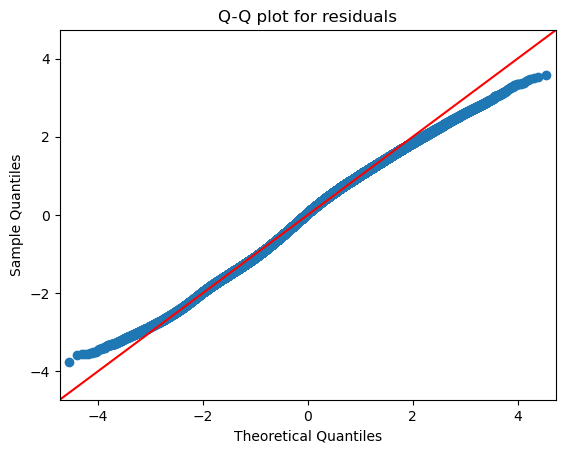

In [70]:
residuals = result.resid
fig = sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q plot for residuals')
plt.show()

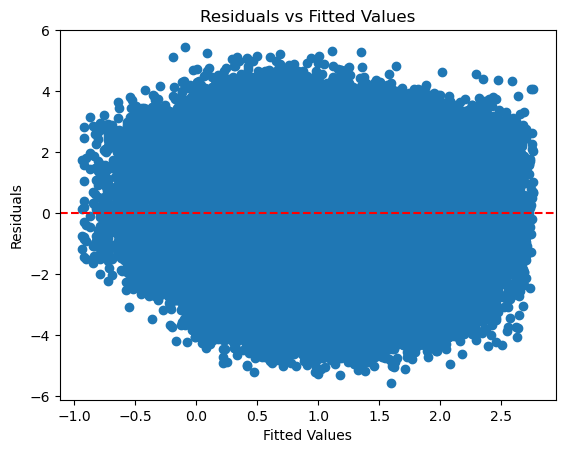

In [40]:
# Residual plot
fitted_values = result.fittedvalues
residuals = result.resid

plt.scatter(fitted_values, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

In [42]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[['ratio', 'PHENO', 'ref_pop', 'gwas_pop', 'CNT_ratio']]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

     feature       VIF
0      ratio  3.016250
1      PHENO  1.729190
2    ref_pop  2.011182
3   gwas_pop  1.988342
4  CNT_ratio  5.736528


                            OLS Regression Results                            
Dep. Variable:             SCORE_norm   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     4956.
Date:                Fri, 06 Dec 2024   Prob (F-statistic):               0.00
Time:                        02:09:01   Log-Likelihood:            -6.8834e+05
No. Observations:              368893   AIC:                         1.377e+06
Df Residuals:                  368891   BIC:                         1.377e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4028      0.004    313.753      0.0

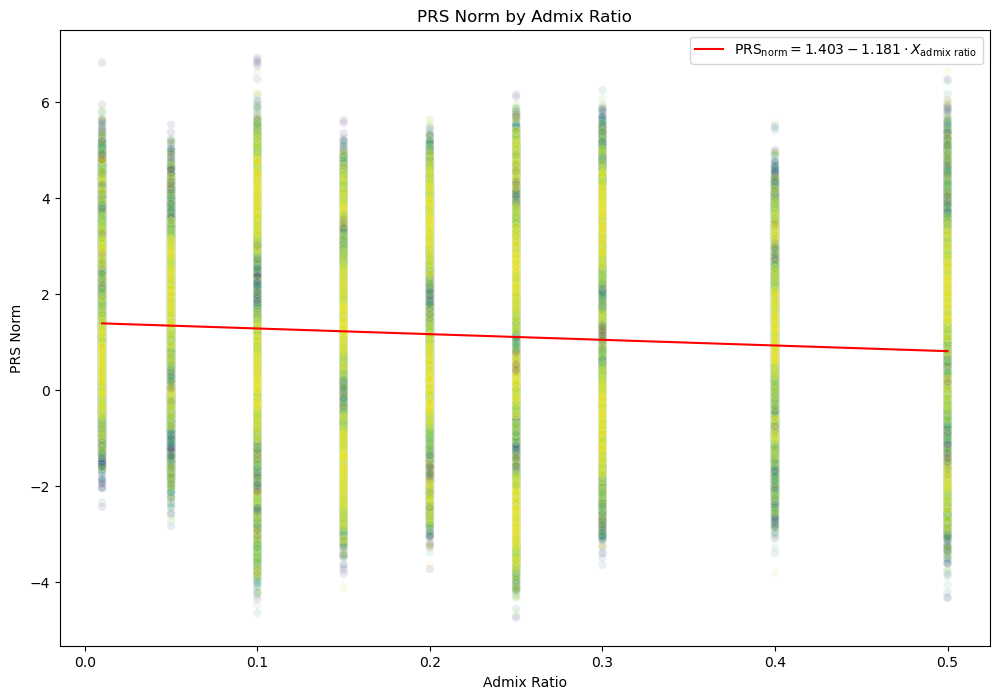

In [104]:
# simple linear regression
formula = 'SCORE_norm ~ ratio'

# Fit the linear model
model_lr1 = smf.ols(formula, data=df).fit()

# Print the summary of the model
print(model_lr1.summary())


# Plotting
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(data=df, x='ratio', y='SCORE_norm', hue='IID', palette='viridis', legend=None, alpha=0.1)
plt.title('Scatter Plot of SCORE_norm by Ratio for each Simulation')
plt.xlabel('Ratio')
plt.ylabel('SCORE_norm')


# Generate a range of ratio values from 0.01 to 0.5
x_values = df['ratio']


# Predict the y values using the mixed-effects model
y_predicted = model_lr1.predict(x_values)

# Overlay the predictions on the existing plot
plt.plot(x_values, y_predicted, 'r-', label=r'$\text{PRS}_{\text{norm}} = 1.403 - 1.181 \cdot X_{\text{admix ratio}}$')

# Customizing the plot
plt.xlabel('Admix Ratio')
plt.ylabel('PRS Norm')
plt.title('PRS Norm by Admix Ratio')
plt.legend()

# Show the plot
plt.show()

# Visualize the individual effects

In [82]:
df_g = df.groupby(['IID', 'gwas_pop', 'ref_pop', 'ratio']).agg({'SCORE_norm': 'mean'}).reset_index()

# Creating a new column 'group_id' that uniquely identifies each group combination of ['IID', 'gwas_pop', 'ref_pop']
df_g['sim_id'] = df_g['IID'].astype(str) + '_' + df_g['gwas_pop'].astype(str) + '_' + df_g['ref_pop'].astype(str)


# Display the new DataFrame
print(df_g)

            IID  gwas_pop  ref_pop  ratio  SCORE_norm        sim_id
0      10001201         0        0   0.01    1.969155  10001201_0_0
1      10001201         0        0   0.05    1.551504  10001201_0_0
2      10001201         0        0   0.10    0.430396  10001201_0_0
3      10001201         0        0   0.15    1.035029  10001201_0_0
4      10001201         0        0   0.20    1.833759  10001201_0_0
...         ...       ...      ...    ...         ...           ...
74227  US330919         1        1   0.20    1.501170  US330919_1_1
74228  US330919         1        1   0.25    1.191023  US330919_1_1
74229  US330919         1        1   0.30    0.342001  US330919_1_1
74230  US330919         1        1   0.40    0.933147  US330919_1_1
74231  US330919         1        1   0.50    0.649787  US330919_1_1

[74232 rows x 6 columns]


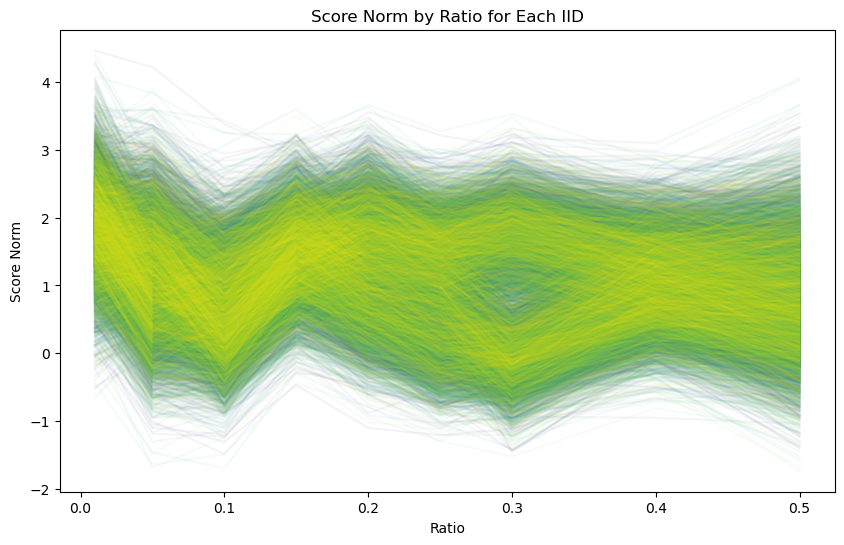

In [61]:
# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_g, x='ratio', y='SCORE_norm', hue='sim_id', legend=None, palette='viridis', alpha=0.05)

# Customizing the plot
plt.xlabel('Ratio')
plt.ylabel('Score Norm')
plt.title('Score Norm by Ratio for Each IID')

# Show the plot
plt.show()

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: SCORE_norm  
No. Observations: 368893  Method:             REML        
No. Groups:       2062    Scale:              2.3140      
Min. group size:  174     Log-Likelihood:     -680677.5629
Max. group size:  179     Converged:          Yes         
Mean group size:  178.9                                   
-----------------------------------------------------------
           Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept   1.403     0.009  154.408  0.000   1.385   1.420
ratio      -1.181     0.016  -72.372  0.000  -1.213  -1.149
Group Var   0.131     0.003                                



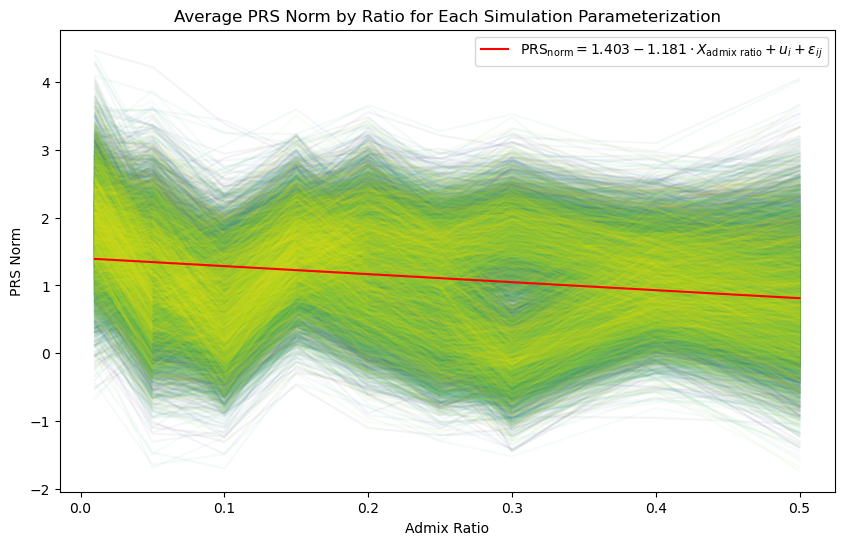

In [101]:
# Assuming 'df' is your DataFrame and 'sim_id' represents each unique simulation setup
model_mlm1 = smf.mixedlm("SCORE_norm ~ ratio", 
                         df, 
                         groups=df["IID"], 
                         re_formula="1")  # Random intercept for each IID
result = model_mlm1.fit()
print(result.summary())

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_g, x='ratio', y='SCORE_norm', hue='sim_id', legend=None, palette='viridis', alpha=0.05)

# Generate a range of ratio values from 0.01 to 0.5
x_values = df['ratio']

# Create a new DataFrame for predictions
df_pred = pd.DataFrame({'ratio': x_values, 'IID': df['IID']})

# Predict the y values using the mixed-effects model
y_predicted = result.predict(df_pred)

# Overlay the predictions on the existing plot
plt.plot(x_values, y_predicted, 'r-', label=r'$\text{PRS}_{\text{norm}} = 1.403 - 1.181 \cdot X_{\text{admix ratio}} + u_{i} + \epsilon_{ij}$')

# Customizing the plot
plt.xlabel('Admix Ratio')
plt.ylabel('PRS Norm')
plt.title('Average PRS Norm by Ratio for Each Simulation Parameterization')
plt.legend()

# Show the plot
plt.show()

# Wrong models

Models I am not using because they are controlling for things wrong

In [22]:
# Assuming 'df' is your DataFrame
model = smf.mixedlm("SCORE_norm ~ ratio", 
                    df, 
                    groups=df["IID"], 
                    re_formula="1",
                    vc_formula={"IID:replicate": "0 + C(replicate)"})
result = model.fit()
print(result.summary())

            Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  SCORE_norm  
No. Observations:  368893   Method:              REML        
No. Groups:        2062     Scale:               2.1135      
Min. group size:   174      Log-Likelihood:      -670849.5430
Max. group size:   179      Converged:           Yes         
Mean group size:   178.9                                     
-------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          1.401    0.009 155.372 0.000  1.384  1.419
ratio             -1.180    0.016 -75.665 0.000 -1.211 -1.150
Group Var          0.082    0.003                            
IID:replicate Var  0.248    0.003                            



Model 1: Basic Model

    Formula: SCORE_norm ~ ratio
    Interpretation:
        Intercept (1.401): The average SCORE_norm when ratio equals 0 is approximately 1.401.
        Ratio Coefficient (-1.180): This negative coefficient suggests that an increase in the ratio is associated with a decrease in SCORE_norm, and each unit increase in ratio decreases SCORE_norm by approximately 1.180 units.
        Random Effects:
            Group Variance (0.082) for IID: Indicates variability in the intercept across different IID groups.
            Replicate Variance within IID (0.248): Suggests additional variability in SCORE_norm across different replicates within the same IID.


In [23]:
# Assuming 'df' is your DataFrame
model = smf.mixedlm("SCORE_norm ~ ratio + gwas_pop + ref_pop + PHENO + CNT_ratio", 
                    df, 
                    groups=df["IID"], 
                    re_formula="1",
                    vc_formula={"IID:replicate": "0 + C(replicate)"})
result = model.fit()
print(result.summary())

             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   SCORE_norm  
No. Observations:   368893    Method:               REML        
No. Groups:         2062      Scale:                1.9689      
Min. group size:    174       Log-Likelihood:       -658164.5365
Max. group size:    179       Converged:            Yes         
Mean group size:    178.9                                       
----------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|  [0.025 0.975]
----------------------------------------------------------------
Intercept         -14.712    3.197   -4.602 0.000 -20.978 -8.446
ratio              -1.178    0.015  -78.258 0.000  -1.208 -1.149
gwas_pop           -0.625    0.005 -134.336 0.000  -0.634 -0.615
ref_pop             0.418    0.005   88.727 0.000   0.409  0.427
PHENO               0.042    0.017    2.405 0.016   0.008  0.076
CNT_ratio          21.796    4.304    5

Model 2: Expanded Model with gwas_pop, ref_pop, PHENO, and CNT_ratio

    Formula: SCORE_norm ~ ratio + gwas_pop + ref_pop + PHENO + CNT_ratio
    Interpretation:
        Intercept (-14.712): A lower baseline for SCORE_norm, possibly reflecting adjustments for additional predictors. The negative value might be less interpretable directly but indicates a shift due to the inclusion of other variables.
        ratio (-1.178): Consistency in the negative effect of ratio across models underscores its robust influence in reducing SCORE_norm when the ancestry proportion is mixed.
        gwas_pop (-0.625) and ref_pop (0.418): Reflect the individual effects of these ancestries on SCORE_norm. A negative coefficient for gwas_pop suggests that the second ancestry in the GWAS population is associated with a lower SCORE_norm, while a positive coefficient for ref_pop suggests an enhancing effect from the second ancestry in the reference population. This might imply that the reference population’s second ancestry aligns better with the traits or markers associated with higher SCORE_norm.
        PHENO (0.042) and CNT_ratio (21.796): Direct effects of phenotype and normalized count ratios are significant, with PHENO showing a slight increase and CNT_ratio showing a strong positive impact on SCORE_norm. This emphasizes the importance of phenotypic traits and count ratios in influencing genetic scoring.
        Random Effects: Similar to Model 1, indicating the importance of accounting for individual and replicate variability.


In [27]:
# Assuming 'df' is your DataFrame
model = smf.mixedlm("SCORE_norm ~ ratio * gwas_pop * ref_pop + PHENO + ratio:CNT_ratio + CNT_ratio", 
                    df, 
                    groups=df["IID"], 
                    re_formula="1",
                    vc_formula={"IID:replicate": "0 + C(replicate)"})
result = model.fit()
print(result.summary())

               Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    SCORE_norm  
No. Observations:    368893     Method:                REML        
No. Groups:          2062       Scale:                 1.9533      
Min. group size:     174        Log-Likelihood:        -656740.4738
Max. group size:     179        Converged:             Yes         
Mean group size:     178.9                                         
-------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
-------------------------------------------------------------------
Intercept              -9.084    3.440  -2.641 0.008 -15.826 -2.342
ratio                   3.867    5.618   0.688 0.491  -7.145 14.878
gwas_pop               -0.508    0.011 -44.677 0.000  -0.530 -0.485
ratio:gwas_pop         -1.010    0.042 -23.794 0.000  -1.093 -0.927
ref_pop                 0.193    0.011  16.965 0.000   0.171  0

In [33]:
# interesting, but I don't actually want to control for variation in the simulations, since this is an effect I am trying to measure itself

# # Assuming 'df' is your DataFrame and 'replicate_id' uniquely identifies each simulation run with a different seed
# model = smf.mixedlm("SCORE_norm ~ ratio + gwas_pop + ref_pop + PHENO", 
#                     df, 
#                     groups=df["IID"], 
#                     re_formula="1",  # Random intercept for each IID
#                     vc_formula={"replicate": "0 + C(replicate)"})  # Random intercept for each replicate
# result = model.fit()
# print(result.summary())


# Supplemental

In [ ]:
def list_files_with_extension(target_dir, extension):
    # Ensure the extension starts with a dot
    if not extension.startswith('.'):
        extension = '.' + extension
    
    # List all files in the directory with the specific extension
    try:
        matching_files = [f for f in os.listdir(target_dir) if f.endswith(extension)]
    except FileNotFoundError:
        print(f"Directory not found: {target_dir}")
        return []
    matching_files.sort()
    
    return matching_files

def read_files(target_dir, extension):
    file_list = list_files_with_extension(target_dir, extension)
    df_dict = {}
    file_keys = []
    for file in file_list:
        file_path = os.path.join(target_dir, file)
        file_key = file.split("_plink")[0]
        file_keys.append(file_key)
        
        try:
            df_dict[file_key] = pd.read_fwf(file_path, header=0)
        except Exception as e:
            print(f"Failed to read {file_path}: {str(e)}")
    
    return df_dict, file_keys


target_dir = '/wynton/scratch/BMI206_NIC/noahs_project/plink_out'
extension = '.profile'
try:
    amr, amr_runs = read_files(target_dir, extension)
except Exception as e:
    print(f"Error during file processing: {str(e)}")